# Configuration and data import

In [1]:
! pip install transformers
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.express as px

import torch
import transformers as ppb # pytorch transformers

from sklearn import kernel_ridge
from sklearn import metrics
from sklearn import neighbors
from sklearn import dummy
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

     |████████████████████████████████| 2.5MB 13.1MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 901kB 53.0MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_train =  pd.read_csv('/content/drive/MyDrive/P8_kaggle/train.csv')
data_test =  pd.read_csv('/content/drive/MyDrive/P8_kaggle/test.csv')

In [4]:
data_train.head(5)

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
data_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [6]:
data_train = data_train[['excerpt', 'target']]
data_train.head(5)

,excerpt,target
0,When the young people returned to the ballroom...,-0.340259
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
2,"As Roger had predicted, the snow departed as q...",-0.580118
3,And outside before the palace a great garden w...,-1.054013
4,Once upon a time there were Three Bears who li...,0.247197


# DistilBert

In [7]:
# create DistilBert model

# Want BERT insteadof distilBERT?change for those :
# (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# from transformers import DistilBertTokenizerFast
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                                    do_lower_case=True)
model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
tokenized = data_train.excerpt.apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized.shape

(2834,)

In [11]:
max_len = 0
min_len = 1000
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
    if len(i) < min_len:
        min_len = len(i)

print('min length of text :', min_len)
print('max length of text :', max_len)

# cropping : keep min number of tokens for all sentences
# padded = np.array([i[:min_len] for i in tokenized.values])

# padding : add 0 to reach max number of tokens for all sentences
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print('X shape :', padded.shape)

min length of text : 158
max length of text : 314
X shape : (2834, 314)


In [12]:
# needed if padding has been done
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2834, 314)

In [14]:
# distilbert
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

last_hidden_states = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
          print('{} / {}'.format(i, len(input_ids)))
          ins = input_ids[i:i+batch_size]
          atts = attention_mask[i:i+batch_size]
          h = model(ins, attention_mask=atts)
          last_hidden_states.extend(h[0])
          
print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states))

# prend trop de RAM de faire tout d'un coup
# with torch.no_grad():
#    last_hidden_states = model(input_ids, attention_mask=attention_mask)
# last_hidden_states[0].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



0 / 2834
200 / 2834
400 / 2834
600 / 2834
800 / 2834
1000 / 2834
1200 / 2834
1400 / 2834
1600 / 2834
1800 / 2834
2000 / 2834
2200 / 2834
2400 / 2834
2600 / 2834
2800 / 2834
elapsed time :  1892.2016203403473
hidden states :  2834


In [15]:
# last_hidden_states = 2834 lines -> 314 characters -> 768 hidden features
len(last_hidden_states[0][0])

768

# Regression

## Features, labels, functions

In [16]:
labels = data_train['target']
labels

0      -0.340259
1      -0.315372
2      -0.580118
3      -1.054013
4       0.247197
          ...   
2829    1.711390
2830    0.189476
2831    0.255209
2832   -0.215279
2833    0.300779
Name: target, Length: 2834, dtype: float64

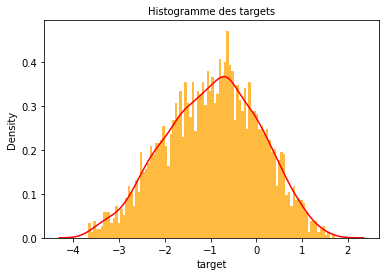

In [17]:
sns.histplot(data=data_train, x="target", bins=100, color='orange',
            edgecolor=None, stat='density',)
sns.kdeplot(data=data_train, x="target", color='red')
plt.title('Histogramme des targets', fontsize=10)
plt.show()

In [18]:
# on ne récupère pour chaque phrase que les 768 hidden du 1er caractère = 101 = CLS = signification phrase
features = []
for i in range(len(last_hidden_states)):
    sent = last_hidden_states[i]
    first_hidden = sent[0]
    features.append(first_hidden.numpy())
features = np.array(features)
features.shape

(2834, 768)

In [19]:
# split into train and validation set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [20]:
def print_save(model_name, model_type, rmse=0, r2=0, time=0):
    """enregistre les résultats de tous les modèles pour les comparer"""
    print(model_name)
    print("RMSE: {:.3f}".format(rmse))
    print('Coeff de détermination Rcarré : {:.3f}'.format(r2))
    
    if model_name in res['modèle'].values :
        res.loc[res['modèle'] == model_name, 'RMSE'] = np.round(rmse, 3)
        res.loc[res['modèle'] == model_name, 'R2'] = np.round(r2, 3)
        res.loc[res['modèle'] == model_name, 'time'] = np.round(time, 2)
        
    else:
        res.loc[len(res)] = {'modèle': model_name,
                     'type' : model_type,
                     'RMSE': np.round(rmse, decimals=3),
                     'R2': np.round(r2, decimals=3),
                    'time': np.round(time, decimals=2)}

# initialisation tableau de stockage des résultats
res = pd.DataFrame(columns=['modèle', 'type', 'RMSE', 'R2', 'time'])

def show_res(yTest, yPred):
    """affiche les courbes résultat"""
    fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
    xmin = np.min(yTest)-1
    xmax = np.max(yTest)+1
    axes[0].scatter(yTest, yPred, color='coral', s=1.5)
    axes[0].plot([xmin, xmax], [xmin, xmax])
    axes[0].set_xlabel('Y test observé')
    axes[0].set_ylabel('Y prediction')
    axes[0].set_title('Comparaison prédiction / observation (jeu de test)')
  
    residuals = yTest - yPred
    moy_residuals = np.mean(residuals)
    lab = 'Moyenne residuals(' + str(np.round(moy_residuals, decimals=2)) + ')'

    xmin = np.min(yPred) - 1
    xmax = np.max(yPred) + 1
    axes[1].scatter(yPred,residuals, color='red', s=1.5)
    axes[1].plot([xmin, xmax], [0, 0], color='grey', alpha=0.5, linewidth=0.5)
    axes[1].plot([xmin, xmax], [moy_residuals, moy_residuals],
                 color='green',linewidth=0.5, label=lab)
    axes[1].set_xlabel('Y prédiction')
    axes[1].set_ylabel('Residuals')
    axes[1].legend()
    axes[1].set_title('Residuals')
    
    plt.show()

## Dummy regressor

Dummy regressor - moyenne
RMSE: 1.015
Coeff de détermination Rcarré : -0.001


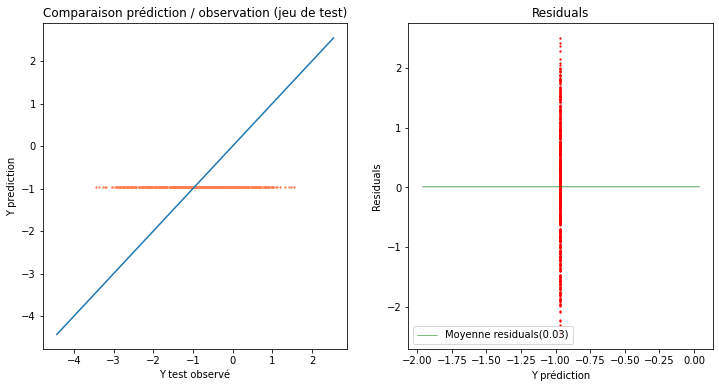

In [21]:
# dummy : moyenne 
dum = dummy.DummyRegressor(strategy='mean')

# entrainement
start_time = time.time()
dum.fit(X_train, y_train)
elapsed = time.time() - start_time

# predictions
y_pred_dum = dum.predict(X_test)
rmse_dum = np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum))
r2_dum = metrics.r2_score(y_test, y_pred_dum)

# resultats
print_save(model_name="Dummy regressor - moyenne", model_type='dummy', rmse=rmse_dum, r2=r2_dum, time=elapsed)
show_res(y_test, y_pred_dum)

## Linear regression

Regression
RMSE: 0.645
Coeff de détermination Rcarré : 0.595
time : 0.16111063957214355


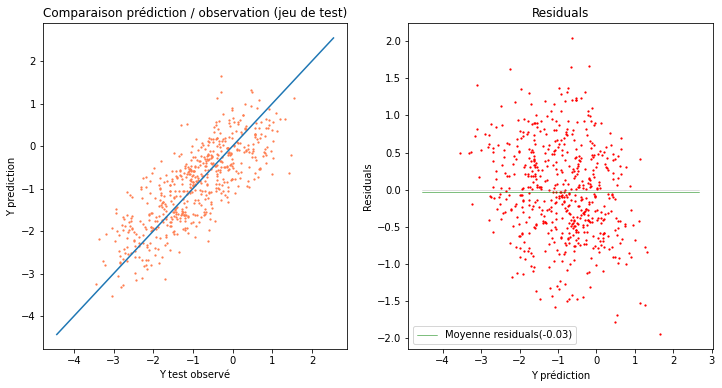

In [22]:
# regression lineaire

# entrainement
start_time = time.time()
regr = LinearRegression().fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred = regr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

# resultats
print_save(model_name="Regression", model_type='linéaire',
           rmse=rmse, r2=r2, time=elapsed)
print('time :', elapsed)
show_res(y_test, y_pred)

alpha optimal : 10.722672220103231
Regression ridge
RMSE: 0.566
Coeff de détermination Rcarré : 0.688
time : 162.1763002872467


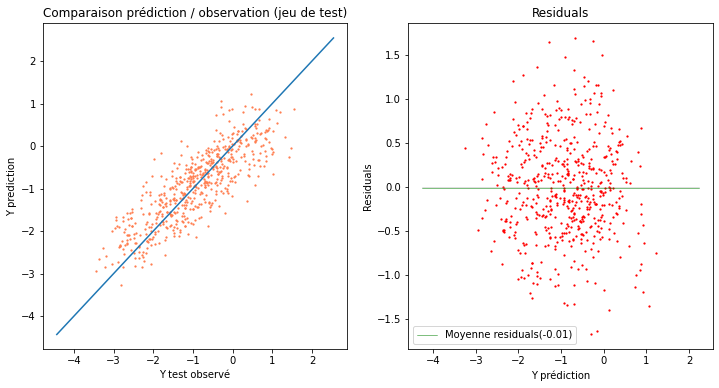

In [23]:
# regression ridge

alphas = np.logspace(0, 3, 100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ridgeCV = RidgeCV(alphas, cv=cv)

# entrainement
start_time = time.time()
ridgeCV.fit(X_train, y_train)
elapsed = time.time() - start_time
print('alpha optimal :', ridgeCV.alpha_)

# prediction
y_pred_ridCV = ridgeCV.predict(X_test)
rmse_ridCV = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridCV))
r2_ridCV = metrics.r2_score(y_test, y_pred_ridCV)

#resultats
print_save(model_name="Regression ridge", model_type='linéaire',
           rmse=rmse_ridCV, r2=r2_ridCV, time=elapsed)
print('time :', elapsed)
show_res(y_test, y_pred_ridCV)

SVR linéaire
RMSE: 0.643
Coeff de détermination Rcarré : 0.598


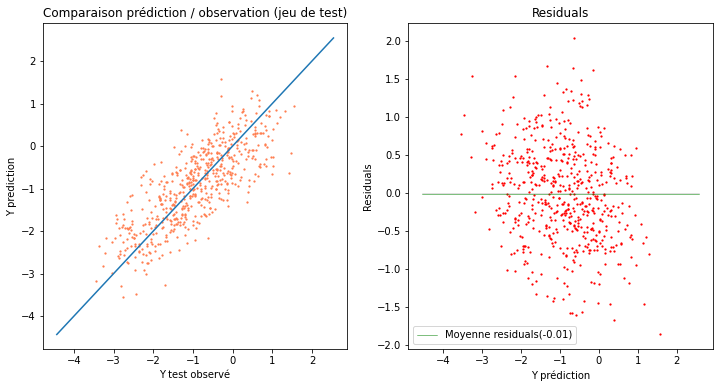

In [24]:
# SVR noyau linéaire
SVR_lin = SVR(kernel = 'linear')

# entrainement
start_time = time.time()
SVR_lin.fit(X_train, y_train)
elapsed = time.time() - start_time

# predictions
y_pred_svrl = SVR_lin.predict(X_test)
rmse_svrl = np.sqrt(metrics.mean_squared_error(y_test, y_pred_svrl))
r2_svrl = metrics.r2_score(y_test, y_pred_svrl)

#resultats
print_save(model_name="SVR linéaire", model_type='linéaire',
           rmse=rmse_svrl, r2=r2_svrl, time=elapsed)
show_res(y_test, y_pred_svrl)

## Non linear methods

Multi Layer Perceptron regressor (500, 500)
RMSE: 0.636
Coeff de détermination Rcarré : 0.607


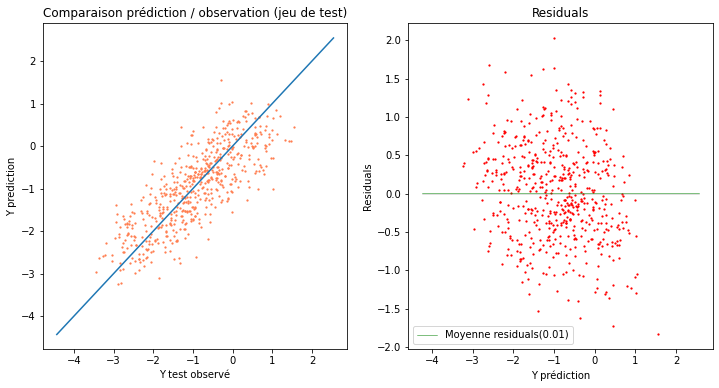

In [25]:
# Multi Layer Perceptron
# hidden layer sizes = tuple (taille de ch couche)
sizes = (500, 500)
MLPregr = MLPRegressor(max_iter=500, hidden_layer_sizes=sizes,
                       activation = 'relu')

start_time = time.time()
MLPregr.fit(X_train, y_train)
elapsed = time.time() - start_time

y_pred_mlp = MLPregr.predict(X_test)
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlp))
r2_mlp = metrics.r2_score(y_test, y_pred_mlp)

#resultats
print_save(model_name="Multi Layer Perceptron regressor {}".format(sizes),
           model_type='non linéaire', rmse=rmse_mlp, r2=r2_mlp, time=elapsed)
show_res(y_test, y_pred_mlp)

Regression Ridge à noyau polynomial
RMSE: 0.565
Coeff de détermination Rcarré : 0.690


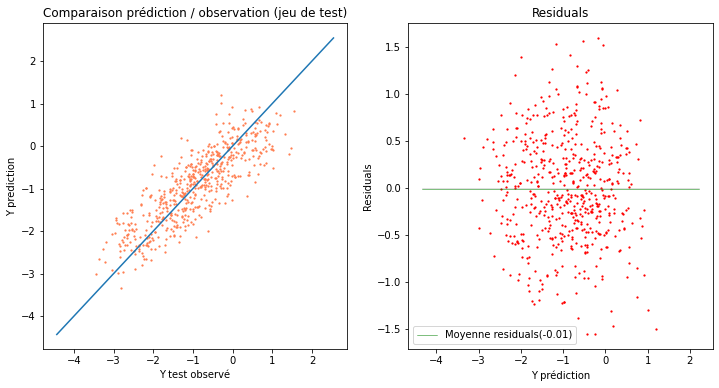

In [26]:
# Ridge Noyau = polynomial + gridsearch

# valeurs des paramètres C, gamma
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

kr_model = GridSearchCV(
        kernel_ridge.KernelRidge(kernel='polynomial'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# entrainement
start_time = time.time()
kr_model.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction avec meilleur modele
y_pred = kr_model.predict(X_test)
rmse_pol = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_pol = metrics.r2_score(y_test, y_pred)

#resultats
print_save(model_name="Regression Ridge à noyau polynomial",
           model_type='non linéaire', rmse=rmse_pol, r2=r2_pol, time=elapsed)
show_res(y_test, y_pred)

Régression Ridge à noyau laplacian
RMSE: 0.586
Coeff de détermination Rcarré : 0.666


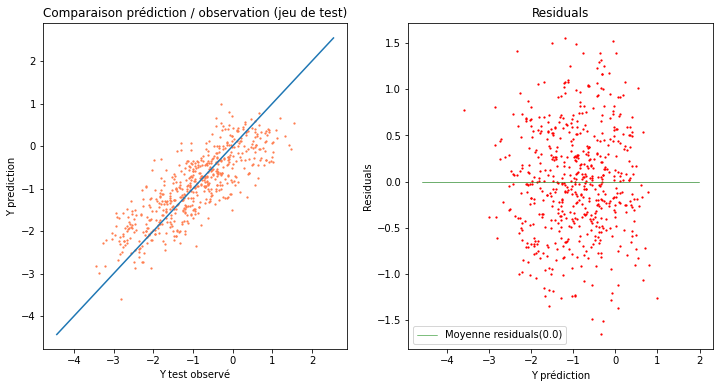

In [27]:
# Ridge Noyau = Laplacian (équivalent exponentiel)

# paramètres
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

score = 'neg_mean_squared_error'

kr_model2 = GridSearchCV(
        kernel_ridge.KernelRidge(kernel='laplacian'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# entrainement
start_time = time.time()
kr_model2.fit(X_train, y_train)
elapsed = time.time() - start_time

# predictions avec meilleur modèle
y_pred = kr_model2.predict(X_test)
rmse_lap = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2_lap = metrics.r2_score(y_test, y_pred)

#resultats
print_save(model_name="Régression Ridge à noyau laplacian",
           model_type='non linéaire', rmse=rmse_lap, r2=r2_lap, time=elapsed)
show_res(y_test, y_pred)

KNeighbors Regressor (k=11)
RMSE: 0.688
Coeff de détermination Rcarré : 0.539


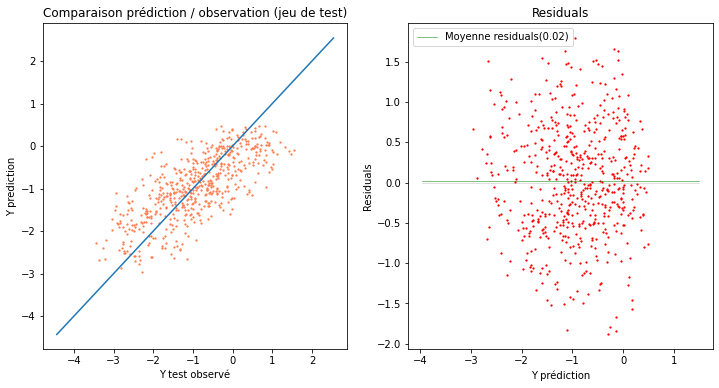

In [28]:
# KNN regressor, recherche k avec validation croisée

param_grid =  {'n_neighbors': [3,5,7,9,11]}
score = 'neg_mean_squared_error'

knnmodel = neighbors.KNeighborsRegressor()
knnCV = GridSearchCV(knnmodel, param_grid, cv=5, scoring=score)

# entrainement
start_time = time.time()
knnCV.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction avec meilleur modele
y_pred_knn = knnCV.predict(X_test)
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn))
r2_knn = metrics.r2_score(y_test, y_pred_knn)

#resultats
n = knnCV.best_estimator_.get_params()['n_neighbors']
print_save(model_name="KNeighbors Regressor (k={})".format(n),
           model_type='non linéaire', rmse=rmse_knn, r2=r2_knn, time=elapsed)
show_res(y_test, y_pred_knn)

SVR noyau RBF
RMSE: 0.580
Coeff de détermination Rcarré : 0.673


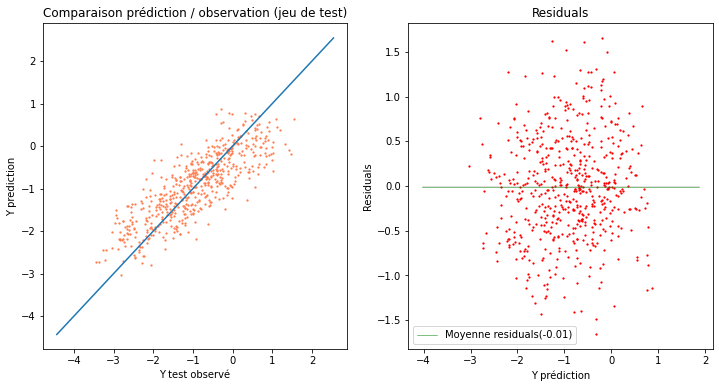

In [29]:
# SVR noyau RBF
SVR_rbf = SVR(kernel = 'rbf')

# entrainement
start_time = time.time()
SVR_rbf.fit(X_train, y_train)
elapsed = time.time() - start_time

# predictions
y_pred_srbf = SVR_rbf.predict(X_test)
rmse_srbf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_srbf))
r2_srbf = metrics.r2_score(y_test, y_pred_srbf)

#resultats
print_save(model_name="SVR noyau RBF", model_type='non linéaire',
           rmse=rmse_srbf, r2=r2_srbf, time=elapsed)
show_res(y_test, y_pred_srbf)

## Ensemble algorithms

Foret aleatoire 200 arbres
RMSE: 0.651
Coeff de détermination Rcarré : 0.588
time : 192.96232199668884


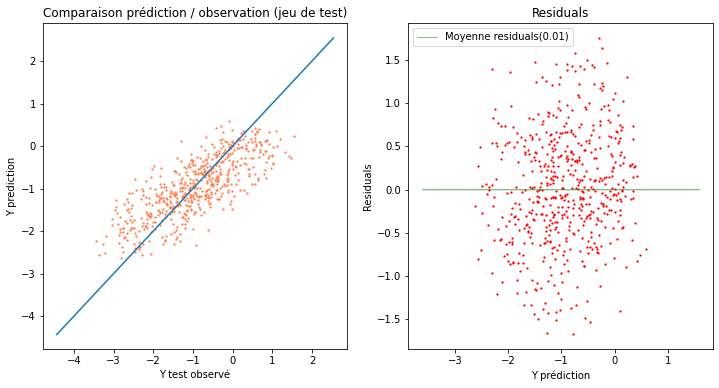

In [30]:
# foret aleatoire
nb = 200
rfr = RandomForestRegressor(n_estimators=nb, oob_score=True)

# entrainement
start_time = time.time()
rfr.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfr))
r2_rfr = metrics.r2_score(y_test, y_pred_rfr)

#resultats
print_save(model_name="Foret aleatoire {} arbres".format(nb),
           model_type='ensembliste', rmse=rmse_rfr, r2=r2_rfr, time=elapsed)
print('time :', elapsed)
show_res(y_test, y_pred_rfr)

[10:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost 
RMSE: 0.639
Coeff de détermination Rcarré : 0.603
time : 8.013459205627441


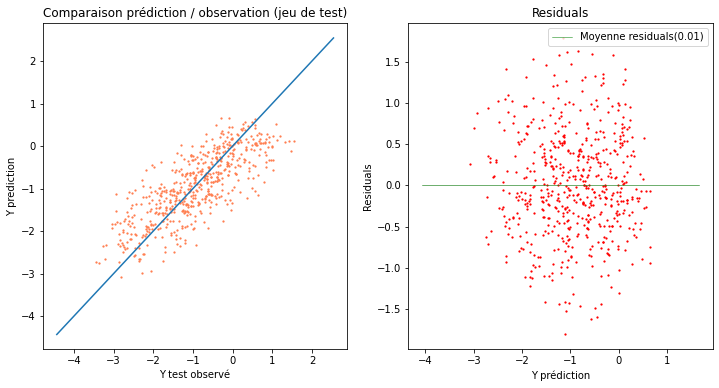

In [31]:
# XG boost
boost = xgb.XGBRegressor()

# entrainement
start_time = time.time()
boost.fit(X_train, y_train)
elapsed = time.time() - start_time

# prediction
y_pred_xgb = boost.predict(X_test)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))
r2_xgb = metrics.r2_score(y_test, y_pred_xgb)

#resultats
print_save(model_name="XG Boost ", model_type='ensembliste',
           rmse=rmse_xgb, r2=r2_xgb, time=elapsed)
print('time :', elapsed)
show_res(y_test, y_pred_xgb)

# Comparaison des résultats

In [32]:
# paramètres pour la comparaison
val_comp = 'RMSE'
level_comp = 'min'

colors = {'dummy':'gold', 'linéaire':'cornflowerblue',
          'non linéaire':'mediumseagreen', 'ensembliste':'tomato'}

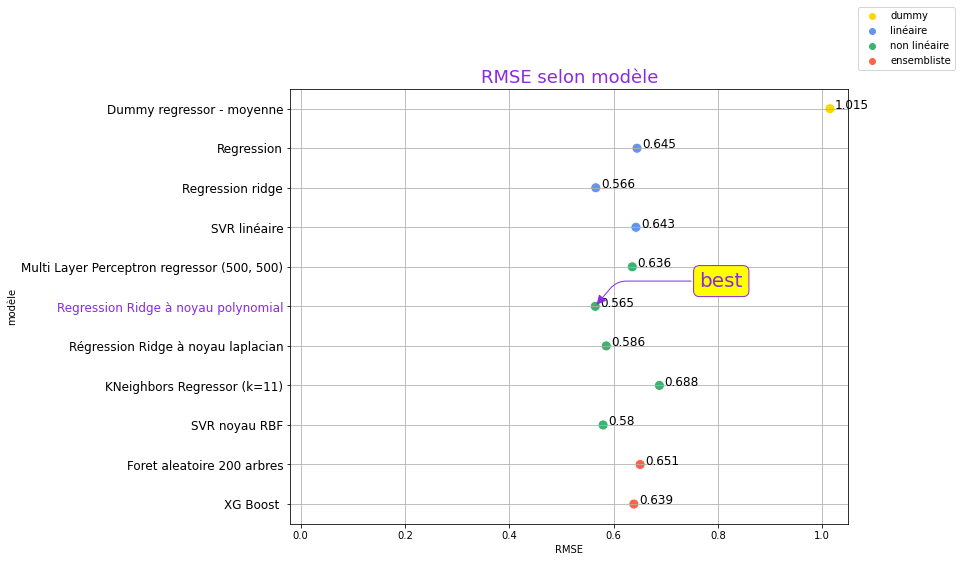

In [33]:
# comparaison des modèles
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=res[val_comp], y=res['modèle'],
                ax=ax, hue=res['type'], palette=colors, s=100)

# display score
for ind in res.index:
    val = res.loc[ind, val_comp]
    plt.text(val + 0.01, ind, str(val), fontsize=12)

# best model
if level_comp == 'min':
    best_comp_ind = res[val_comp].idxmin()
    best_comp_val = res.loc[best_comp_ind, val_comp]
if level_comp == 'max':
    best_comp_ind = res[val_comp].idxmax()
    best_comp_val = res.loc[best_comp_ind, val_comp]

plt.gca().get_yticklabels()[best_comp_ind].set_color('blueviolet') 
plt.yticks(fontsize=12)

arrowprops1 = dict(arrowstyle = "-|>", color="blueviolet",
                   connectionstyle = "angle, angleA=0, angleB=50, rad=10")

bbox_text = dict(boxstyle="round", fc="yellow", color='blueviolet')
ax.annotate("best", xy=(best_comp_val, best_comp_ind),
            xytext=(best_comp_val + 0.2, best_comp_ind - 0.5),
            arrowprops=arrowprops1, bbox=bbox_text,
            color='blueviolet', fontsize=20)

plt.grid()
plt.xlabel(val_comp)
plt.ylabel('modèle')
plt.xlim(-0.02, 1.05)
plt.title('{} selon modèle'.format(val_comp), fontsize=18, color='blueviolet')
plt.legend(loc='best', bbox_to_anchor=(0.2, 0.2, 1, 1))
plt.show()

In [34]:
# comparaison des modèles avec temps d'exécution
if level_comp == 'min':
    val_best = res[val_comp].idxmin()
    x_best = res.loc[val_best, val_comp]
    y_best = res.loc[val_best, 'time']
if level_comp == 'max':
    val_best = res[val_comp].idxmax()
    x_best = res.loc[val_best, val_comp]
    y_best = res.loc[val_best, 'time']

lay = go.Layout(plot_bgcolor='rgba(0,0,0,0)')

fig = (px.scatter(res, x="RMSE", y="time", color='type', hover_name='modèle',
                  color_discrete_map =  {'dummy':'gold',
                                         'linéaire':'cornflowerblue',
                                         'non linéaire':'mediumseagreen',
                                         'ensembliste':'tomato'},
                  )).update_traces(mode="markers", marker_line_width=1.5,
                                   opacity=0.7, marker_size=10)

fig.add_trace(go.Scatter(x=[x_best], y=[y_best], mode="markers",
                         marker_symbol=100, marker_size=20,
                         marker_color='blueviolet', marker_line_width=3,
                         showlegend=False, name='', hoverinfo='skip'))

fig.update_layout(title="Comparaison des modèles",
                  xaxis_title=val_comp,
                  yaxis_title="Temps d'exécution (secondes)",)

fig.update_xaxes(tick0=0, dtick=0.1, range=[-0.02, 1.05])
fig.show()

# Predictions on submission data

In [35]:
# données pour submission
data_test

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ..."
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...


In [36]:
# tokenisation
tokenized_test = data_test.excerpt.str.lower().apply(
    (lambda x: tokenizer.encode(x, add_special_tokens=True)))

# padding
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

# padding : add 0 to reach max number of tokens for all sentences
padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test = np.where(padded_test != 0, 1, 0)

# compute features
input_ids = torch.tensor(padded_test)  
attention_mask = torch.tensor(attention_mask_test)

last_hidden_states_test = []
batch_size = 200

start = time.time()
with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
          print('{} / {}'.format(i, len(input_ids)))
          ins = input_ids[i:i+batch_size]
          atts = attention_mask[i:i+batch_size]
          h = model(ins, attention_mask=atts)
          last_hidden_states_test.extend(h[0])
          
print('elapsed time : ', time.time() - start)
print('hidden states : ', len(last_hidden_states_test))

0 / 7
elapsed time :  6.881873369216919
hidden states :  7


In [37]:
# test features
X_test = []
for i in range(len(last_hidden_states_test)):
    sent = last_hidden_states_test[i]
    first_hidden = sent[0]
    X_test.append(first_hidden.numpy())
X_test = np.array(X_test)
X_test

array([[-0.03748884,  0.09408239, -0.31397158, ...,  0.19926941,
         0.23159926,  0.42704356],
       [-0.425291  , -0.03720773, -0.21280468, ...,  0.12220364,
         0.4951441 ,  0.35905942],
       [-0.31366414,  0.16635543,  0.05724083, ...,  0.12591973,
         0.62576216,  0.36861438],
       ...,
       [-0.49260214, -0.0305856 , -0.58643526, ..., -0.04257688,
         0.08192021,  0.8632848 ],
       [-0.12270702, -0.03694618, -0.29035458, ..., -0.05884869,
         0.5029276 ,  0.53282374],
       [-0.02432724, -0.36998683, -0.0743122 , ...,  0.05013106,
         0.2503379 ,  0.22107092]], dtype=float32)

In [38]:
# prediction
y_test = kr_model.predict(X_test)

# submission file
submission_df = pd.DataFrame({'id': data_test.id, 'target': 0})
submission_df.target = y_test

submission_file = '/content/drive/MyDrive/P8_kaggle/df_submission.csv'
submission_df.to_csv(submission_file, index=False)

submission_df

,id,target
0,c0f722661,-0.620980
1,f0953f0a5,-0.315437
2,0df072751,-0.339799
3,04caf4e0c,-2.864276
4,0e63f8bea,-1.785313
5,12537fe78,-1.347130
6,965e592c0,-0.460693
